## Web Scraping

In [65]:
from __future__ import print_function, division
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import pickle
import time
from datetime import datetime
import math
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


I wanted to create a predictor of opening weekend domestic gross earnings for movies released in theaters.  Full information about the project can be read at______________.


## Webscraping

### Movie List

I used BeautifulSoup to get budget and box office earnings information for movies from www.the-numbers.com.  This website lists information in tables that I could extract data from.  First, I got a list of movies, budgets, and release dates:

In [7]:
# Create pandas dataframe to store records
movies = pd.DataFrame(columns = ['Movie','URL', 'Date', 'Budget'])

# Scrape data
url = 'http://www.the-numbers.com/movie/budgets/all'
response = requests.get(url)
soup = BeautifulSoup(response.text,"lxml")
budget_table=soup.find_all("table")[0]
rows=[row for row in budget_table.find_all('tr')]

#Iterate through table rows
for i, row in enumerate(rows):
    items = row.find_all('td')
    if items:
        temp_row = [items[2].find('a').text]  #Movie
        temp_row.append(items[2].find('a')['href'])  #URL for movie
        temp_row.append(datetime.strptime(items[1].find('a').text, '%m/%d/%Y'))  #Release date 
        temp_row.append(int(items[3].text.replace('$','').replace(',',''))) #Budget
        movies.loc[i] = temp_row

movies = movies.reset_index(drop=True)        
movies.head()

,Movie,URL,Date,Budget
0,Avatar,/movie/Avatar#tab=summary,2009-12-18,425000000.0
1,Star Wars Ep. VII: The Force Awakens,/movie/Star-Wars-Ep-VII-The-Force-Awakens#tab=...,2015-12-18,306000000.0
2,Pirates of the Caribbean: At Worldâs End,/movie/Pirates-of-the-Caribbean-At-Worlds-End#...,2007-05-24,300000000.0
3,Spectre,/movie/Spectre#tab=summary,2015-11-06,300000000.0
4,The Dark Knight Rises,/movie/Dark-Knight-Rises-The#tab=summary,2012-07-20,275000000.0


We only have ticket cost information for 1995 and later, so remove movies released before 1995.

In [ ]:
movies = movies[movies.Date > datetime(1994,12,31)]
pickle.dump(movies, open("movies.p", "wb"))


### Opening Weekend Data, Crew List, and Cast List

Next, for each movie, get the list of top ten cast, list of crew and their credits, the number of theaters the movie opened in, and gross earnings for the opening weekend.

In [ ]:
#Dataframes to store records
#cast = pd.DataFrame(columns = ['Name','Movie','URL'])
#crew = pd.DataFrame(columns = ['Name','Movie','Credit', 'URL'])

url_init = 'http://www.the-numbers.com'

k = 0
for row in movies.iterrows():
    #Keep track of progress
    if k%100==0:
        print(k)
    k+=1
    
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text,"lxml")
        soup_cast = soup.find_all(id='cast')
        
        if len(soup_cast) > 1:
            
            #Cast names and URL
            s_cast = soup_cast[0].find_all('a')
            for c in s_cast[:10]:
                cast.loc[c.text + ' ' + str(row[0])] = [c.text, row[1]['Movie'], c['href']]
                
            #Crew
            s_crew = soup_cast[1].find_all('td')
            for i in range(0,len(s_crew),3):
                
                #Not all movies have crew
                if s_crew[i].text in crew_type:
                    temp_url = s_crew[i+2].find('a')['href']  #URL of cast        
                    crew.loc[s_crew[i+2].text + ' ' + str(row[0])] = \
                        [s_crew[i+2].text, row[1]['Movie'], s_crew[i].text, temp_url]
                        
        #Opening weekend data
        first_wkend_line = soup.find_all(id='box_office_chart')[0].find_all('tr')[1]
        first_wkend = first_wkend_line.find_all('td')
        NTheater = first_wkend[4].text.replace(',','')  #Number of theaters movie opened in
        OpnWkendBoxOffice = int(first_wkend[2].text.replace('$','').replace(',','')) #Box office gross earnings
        open_wkend.loc[row[0]] = [row[1]['Movie'], NTheater, OpnWkendBoxOffice]

        time.sleep(1) #Don't access website too much at once

    except:
        print("Error for:", url)
        time.sleep(.2)
        

In [15]:
crew = crew.reset_index(drop=True)
cast = cast.reset_index(drop=True)

Save data

In [ ]:
#pickle.dump(cast, open("cast.p", "wb"))
#pickle.dump(crew, open("crew.p", "wb"))
#pickle.dump(open_wkend, open("open_wkend.p", "wb"))

### Cast and Crew Data

Checkpoint... Get data if needed for work below.

In [419]:
cast = pd.read_pickle("cast.p")
crew = pd.read_pickle("crew.p")
open_wkend = pd.read_pickle("open_wkend.p")
movies = pd.read_pickle("movies.p")

In [424]:
crew_type = ['Director', 'Executive Producer', 'Producer', 'Screenwriter', 'Editor', 'Composer', 'Cinematographer']
crew = crew[crew['Credit'].isin(crew_type)].reset_index(drop=True)


Get list of all names and urls to go through all cast and crew, then get a list of who is in cast and who is in crew.

In [199]:
crew_list = crew[['Name','URL']]
cast_list = cast[['Name','URL']]
person_list = crew_list.append(cast_list).drop_duplicates().reset_index(drop=True)

cast_names = list(cast['Name'].unique())
crew_names = list(crew['Name'].unique())


In [200]:
person_list.head()

,Name,URL
0,James Cameron,/person/23100401-James-Cameron
1,Jon Landau,/person/190420401-Jon-Landau
2,Colin Wilson,/person/206830401-Colin-Wilson
3,Laeta Kalogridis,/person/423570401-Laeta-Kalogridis
4,Stephen Rivkin,/person/121990401-Stephen-Rivkin


In [201]:
len(person_list)

22211

Get the cast and crew records.  For each movie they are in, record how many movies they were in before, and the accumulated total box office gross of the previous movies.

Create columns for number of movies and accumulated gross before current movie.

In [202]:
crew['Nmovie'] = pd.Series([np.nan]*len(crew))
crew['GrossAccum'] = pd.Series([np.nan]*len(crew))
cast['Nmovie'] = pd.Series([np.nan]*len(cast))
cast['GrossAccum'] = pd.Series([np.nan]*len(cast))
cast = cast.reset_index(drop=True)
crew = crew.reset_index(drop=True)

Some movies names are too long for the cast/crew listings.  Use the URLs instead of movie names.

In [212]:
url_init = 'http://www.the-numbers.com'
k = 0
person_list = person_list.sort_values('Name')

for person in person_list.iterrows():
    #To keep track of progress
    if k%100==0:
        print(k)
    k+=1
        
    try:
        name = person[1]['Name']
        url = url_init + person[1]['URL']
        response = requests.get(url)
        soup = BeautifulSoup(response.text,"lxml")

        if name in cast_names:
            budget_table = soup.find_all(id='acting')[0].find_all(id='page_filling_chart')[0]
            budget_rows = budget_table.find_all('tr')
            tot_gross = 0

            for n_mov, row in enumerate(budget_rows[-3:0:-1]):

                #Get name of movie and check if needed for person
                mov = row.find('a', href=True).text.strip()
                idx = cast[(cast['Name']==person[1]['Name']) & (cast['Movie']==mov)].index

                if len(idx):
                    cast.iloc[idx, 3] = n_mov
                    cast.iloc[idx, 4] = tot_gross   

                #Get gross total as data for next movies
                tot_gross+=int(row.find_all('td')[3].text.strip('$').replace(',',''))


        if name in crew_names:
            tech_table = soup.find_all(id='technical')[0].find_all(id='page_filling_chart')[0]
            tech_rows = tech_table.find_all('tr')
            accum_data = pd.DataFrame(index = crew_type, columns=['tot_gross','n_mov'], data=[0][0]*len(crew_type))

            for n_mov, row in enumerate(tech_rows[-3:0:-1]):
                #Get movies and credits
                mov = row.find('a', href=True).text
                creds = row.find_all('td')[2].text

                #Check if there are multiple credits for the movie
                if len(creds)>0:
                    creds = creds.split(',')

                for cred in creds:
                    cred = cred.strip()
                    if cred in crew_type:
                        idx = crew[(crew['Name']==name) & (crew['Movie']==mov) & \
                                               (crew['Credit']==cred)].index
                        if len(idx):
                            crew.iloc[idx, 4] = accum_data.loc[cred, 'n_mov']
                            crew.iloc[idx, 5] = accum_data.loc[cred,'tot_gross']  

                        accum_data.loc[cred,'tot_gross']+=int(row.find_all('td')[3].text.strip('$').replace(',',''))
                        accum_data.loc[cred,'n_mov']+=1

        time.sleep(1)
       
    except:
        print("Error for:",person)
        time.sleep(.2)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
Error for: (22095, Name                      Jack Nance
URL     /person/104380401-Jack-Nance
Name: 22095, dtype: object)
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
1

In [213]:
#pickle.dump(cast, open('cast_dat.p', 'wb'))
#pickle.dump(crew, open('crew_dat.p', 'wb'))

## Data Processing

Checkpoint...

In [454]:
cast_dat = pd.read_pickle("cast_dat.p")
cast_dat = cast_dat.dropna()
crew_dat = pd.read_pickle("crew_dat.p")
crew_dat = crew_dat.dropna()
movies = pd.read_pickle('movies.p')
open_wkend = pd.read_pickle("open_wkend.p")


Check for number of each crew position.

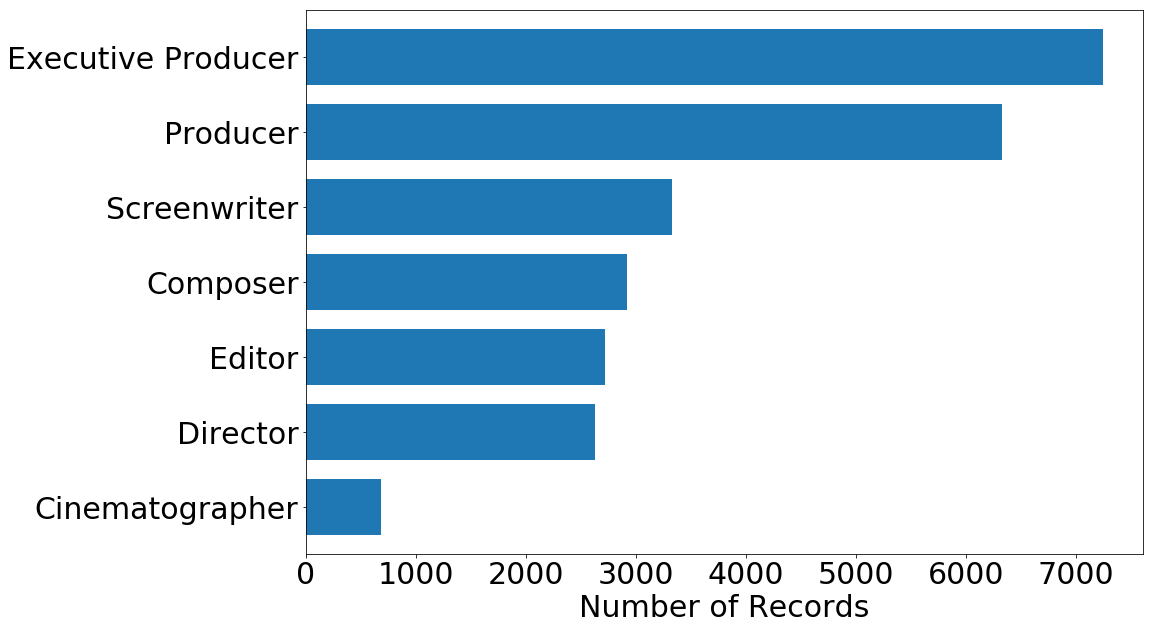

In [455]:
credit_hist = crew_dat['Credit'].value_counts().sort_values()
plt.figure(figsize=(15,10))
credit_hist.plot(kind='barh', width=.75)
plt.xlabel('Number of Records', fontsize=30);
plt.ylabel('', fontsize=30);
plt.tick_params(labelsize=30)

Let's drop cinematographers.

In [456]:
crew_dat = crew_dat[crew_dat['Credit']!='Cinematographer']
crew_type = ['Director', 'Executive Producer', 'Producer', 'Screenwriter', 'Editor', 'Composer']


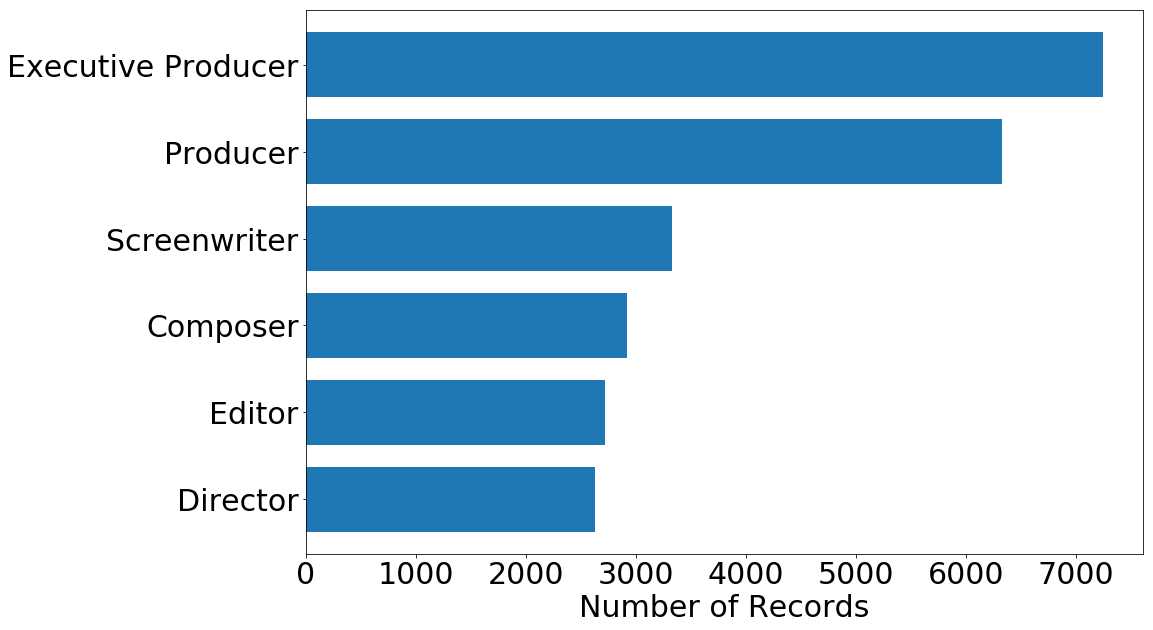

In [457]:
credit_hist = crew_dat['Credit'].value_counts().sort_values()
plt.figure(figsize=(15,10))
credit_hist.plot(kind='barh', width=.75)
plt.xlabel('Number of Records', fontsize=30);
plt.ylabel('', fontsize=30);
plt.tick_params(labelsize=30)

Find max and total of number of movies and accumulated gross for each credit/movie.

In [346]:
crew_stats = crew_dat.groupby(['Movie','Credit'])['Nmovie','GrossAccum'].agg([np.sum, np.max])
movies_dat = movies.copy()

level0 = ['Nmovie','GrossAccum']
level1 = ['sum', 'amax']

for l0 in level0:
    for l1 in level1:
        stats = crew_stats[l0][l1].unstack()
        stats.columns = stats.columns+l0+l1
        stats = stats.reset_index()
        movies_dat = pd.merge(movies_dat, stats, on='Movie', how='inner')
        
movies_dat.drop(['URL','DomestGross','InterGross'], axis=1, inplace=True)

In [347]:
crew_sum = crew_dat.groupby('Movie')['Nmovie','GrossAccum'].sum()
crew_sum = crew_sum.rename(columns={'Nmovie':'CrewNmoviesum', 'GrossAccum':'CrewGrossAccumsum'})
crew_sum = crew_sum.reset_index()
movies_dat = pd.merge(movies_dat, crew_sum, on='Movie', how='inner')

crew_max = crew_dat.groupby('Movie')['Nmovie','GrossAccum'].max()
crew_max = crew_max.rename(columns={'Nmovie':'CrewNmovieamax', 'GrossAccum':'CrewGrossAccumamax'})
crew_max = crew_max.reset_index()
movies_dat = pd.merge(movies_dat, crew_max, on='Movie', how='inner')


In [348]:
cast_stats = cast_dat.copy().drop(['URL','Name'], axis=1)
cast_stats = cast_stats.groupby('Movie')['Nmovie','GrossAccum'].agg([np.sum, np.max])

for l0 in level0:
    for l1 in level1:
        stats = cast_stats[l0][l1].to_frame()
        stats = stats.rename(columns = {l1:'Cast'+l0+l1})
        stats = stats.reset_index()
        movies_dat = pd.merge(movies_dat, stats, on='Movie', how='inner')

## Ticket Sales, Number of Theaters, and Year Data

Get year of movie

In [349]:
movies_dat['Year'] = movies_dat['Date'].dt.year
movies_dat.drop('Date', axis=1, inplace=True)

In [350]:
movies_dat.head()

,Movie,Budget,ComposerNmoviesum,DirectorNmoviesum,EditorNmoviesum,Executive ProducerNmoviesum,ProducerNmoviesum,ScreenwriterNmoviesum,ComposerNmovieamax,DirectorNmovieamax,...,ScreenwriterGrossAccumamax,CrewNmoviesum,CrewGrossAccumsum,CrewNmovieamax,CrewGrossAccumamax,CastNmoviesum,CastNmovieamax,CastGrossAccumsum,CastGrossAccumamax,Year
0,Avatar,425000000.0,93.0,NaN,10.0,0.0,2.0,NaN,93.0,NaN,...,NaN,105.0,7.073986e+09,93.0,5.044627e+09,167.0,42.0,5.772328e+09,1.627221e+09,2009
1,Spectre,300000000.0,71.0,6.0,11.0,4.0,17.0,19.0,71.0,6.0,...,1.058548e+09,128.0,1.162141e+10,71.0,3.435108e+09,134.0,40.0,7.313475e+09,2.611997e+09,2015
2,The Dark Knight Rises,275000000.0,77.0,NaN,7.0,32.0,17.0,2.0,77.0,NaN,...,5.864352e+08,135.0,1.863222e+10,77.0,8.602266e+09,296.0,61.0,1.661905e+10,3.424883e+09,2012
3,The Lone Ranger,275000000.0,NaN,NaN,12.0,45.0,26.0,2.0,NaN,NaN,...,6.584194e+07,85.0,1.273745e+10,25.0,3.625050e+09,190.0,47.0,1.179555e+10,3.163822e+09,2013
4,John Carter,275000000.0,18.0,NaN,1.0,NaN,10.0,6.0,18.0,NaN,...,1.494208e+09,35.0,4.829926e+09,18.0,1.968614e+09,138.0,35.0,5.460319e+09,1.387183e+09,2012


Some movies didn't have the number of theaters on opening weekend.  For those, the data returned had the number of theaters the same as the opening weekend box office gross earnings.  A few returned high numbers.  Remove those.

In [426]:
open_wkend['NumTheaters'] = open_wkend['NumTheaters'].astype(float)
open_wkend = open_wkend[open_wkend['NumTheaters']!=open_wkend['OpnWkendBoxOffice']]
open_wkend = open_wkend[open_wkend['NumTheaters'] < 6000]
open_wkend = open_wkend[open_wkend['NumTheaters'] > 0]


In [427]:
open_wkend.sort_values('NumTheaters').head()

,Movie,NumTheaters,OpnWkendBoxOffice
4222,Praia do Futuro,1.0,3324.0
4999,La mariÃ©e Ã©tait en noir,1.0,6463.0
4991,Il conformista,1.0,18702.0
4981,Not Cool,1.0,10329.0
4980,Dod sno,1.0,5363.0


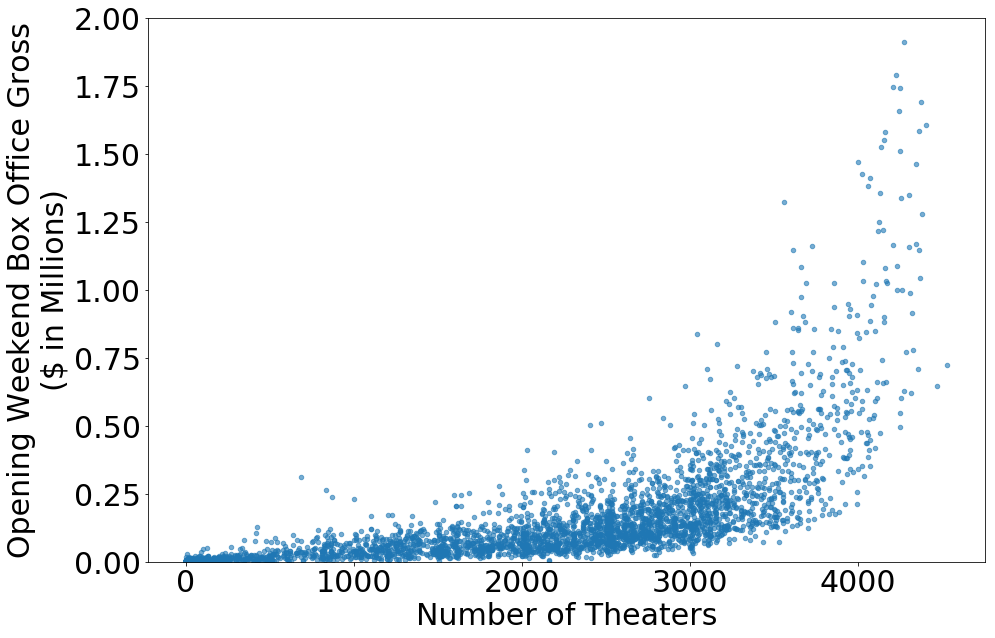

In [428]:
plt.figure(figsize=(15,10))

plt.scatter(open_wkend['NumTheaters'], open_wkend['OpnWkendBoxOffice']/1e8, s=20, alpha=.6)
plt.ylim([0,2])
plt.ylabel('Opening Weekend Box Office Gross\n($ in Millions)', fontsize=30);
plt.xlabel('Number of Theaters', fontsize=30);
plt.tick_params(labelsize=30)

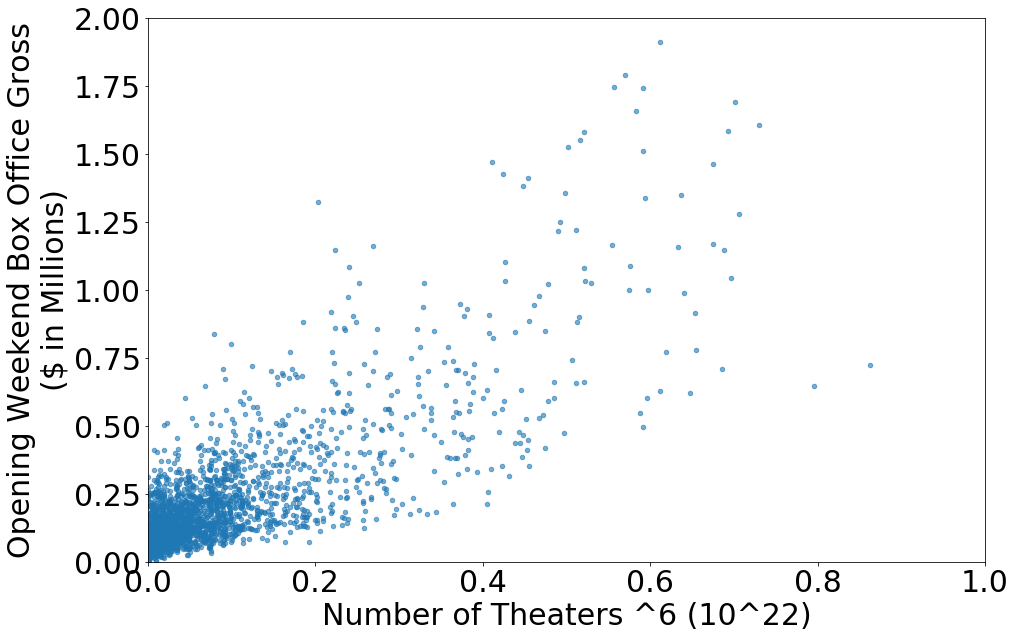

In [429]:
plt.figure(figsize=(15,10))

plt.scatter(np.power(open_wkend['NumTheaters'],6)/1e22, open_wkend['OpnWkendBoxOffice']/1e8, s=20, alpha=.6)
plt.ylim([0,2])
plt.xlim([0,1])
plt.ylabel('Opening Weekend Box Office Gross\n($ in Millions)', fontsize=30);
plt.xlabel('Number of Theaters ^6 (10^22)', fontsize=30);
plt.tick_params(labelsize=30)

In [355]:
open_wkend['NumTheaters3'] = np.power(open_wkend['NumTheaters'],3)
open_wkend['NumTheaters5'] = np.power(open_wkend['NumTheaters'],5)


In [356]:
movies_dat = pd.merge(movies_dat, open_wkend, on='Movie', how='inner')

Get annual ticket sales and total domestic gross earnings for all movies to get worth of tickets.

In [387]:
url = 'http://www.the-numbers.com/market/'
response = requests.get(url)
soup = BeautifulSoup(response.text,"lxml")

ticket_table=soup.find_all("table")[0]
rows=[row for row in ticket_table.find_all('tr')]

tickets = pd.DataFrame(columns = ['Year', 'Tickets', 'TotalBoxOffice'])
for i, row in enumerate(rows[1:]):
    items = row.find_all('td')
    temp_row = [int(items[0].text)]
    temp_row.append(int(items[1].text.replace(',','')))
    temp_row.append(int(items[2].text.replace('$','').replace(',','')))
    tickets.loc[i] = temp_row

tickets['DollarPerTick'] = tickets['TotalBoxOffice'].divide(tickets['Tickets'])
tickets['TickPerDollar'] = tickets['Tickets'].divide(tickets['TotalBoxOffice'])

tickets['Year'] =  tickets['Year'].astype(int)
tickets.index = tickets.Year

In [391]:
tickets

,Year,Tickets,TotalBoxOffice,DollarPerTick,TickPerDollar
Year,,,,,
2017,2017,7.483544e+08,6.473267e+09,8.650002,0.115607
2016,2016,1.300780e+09,1.125175e+10,8.650003,0.115607
2015,2015,1.338949e+09,1.128734e+10,8.430003,0.118624
2014,2014,1.267424e+09,1.035486e+10,8.170002,0.122399
2013,2013,1.339833e+09,1.089285e+10,8.130002,0.123001
2012,2012,1.387147e+09,1.104169e+10,7.960002,0.125628
2011,2011,1.284609e+09,1.018695e+10,7.930002,0.126103
2010,2010,1.331627e+09,1.050654e+10,7.890002,0.126743
2009,2009,1.418842e+09,1.064132e+10,7.500001,0.133333


In [392]:
movies_dat = movies_dat.copy()
movies_dat = pd.merge(movies_dat, tickets, on='Year', how='inner')
movies_dat.head()

,Movie,Budget,ComposerNmoviesum,DirectorNmoviesum,EditorNmoviesum,Executive ProducerNmoviesum,ProducerNmoviesum,ScreenwriterNmoviesum,ComposerNmovieamax,DirectorNmovieamax,...,CastGrossAccumamax,Year,NumTheaters,OpnWkendBoxOffice,NumTheaters3,NumTheaters5,Tickets,TotalBoxOffice,DollarPerTick,TickPerDollar
0,Avatar,425000000.0,93.0,NaN,10.0,0.0,2.0,NaN,93.0,NaN,...,1.627221e+09,2009,3452.0,77025481.0,4.113508e+10,4.901781e+17,1.418842e+09,1.064132e+10,7.500001,0.133333
1,2012,200000000.0,3.0,NaN,9.0,6.0,10.0,NaN,2.0,NaN,...,1.770525e+09,2009,3404.0,65237614.0,3.944288e+10,4.570332e+17,1.418842e+09,1.064132e+10,7.500001,0.133333
2,Terminator Salvation,200000000.0,67.0,3.0,10.0,4.0,25.0,2.0,67.0,3.0,...,1.916430e+09,2009,3530.0,42558390.0,4.398698e+10,5.481173e+17,1.418842e+09,1.064132e+10,7.500001,0.133333
3,Disney's A Christmas Carol,190000000.0,78.0,NaN,2.0,NaN,22.0,NaN,78.0,NaN,...,2.377814e+09,2009,3683.0,30051075.0,4.995801e+10,6.776549e+17,1.418842e+09,1.064132e+10,7.500001,0.133333
4,Up,175000000.0,8.0,NaN,0.0,8.0,0.0,1.0,8.0,NaN,...,3.099245e+09,2009,3766.0,68108790.0,5.341226e+10,7.575330e+17,1.418842e+09,1.064132e+10,7.500001,0.133333


## Modeling



In [393]:
df = movies_dat.drop('Movie', axis=1).dropna()
df_cols = df.columns
#df = preprocessing.normalize(df, axis=0)
#df = pd.DataFrame(df, columns = df_cols)

y = df['OpnWkendBoxOffice']
X = df.drop('OpnWkendBoxOffice', 1)


In [394]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 708 entries, 2 to 3238
Data columns (total 42 columns):
Budget                              708 non-null float64
ComposerNmoviesum                   708 non-null float64
DirectorNmoviesum                   708 non-null float64
EditorNmoviesum                     708 non-null float64
Executive ProducerNmoviesum         708 non-null float64
ProducerNmoviesum                   708 non-null float64
ScreenwriterNmoviesum               708 non-null float64
ComposerNmovieamax                  708 non-null float64
DirectorNmovieamax                  708 non-null float64
EditorNmovieamax                    708 non-null float64
Executive ProducerNmovieamax        708 non-null float64
ProducerNmovieamax                  708 non-null float64
ScreenwriterNmovieamax              708 non-null float64
ComposerGrossAccumsum               708 non-null float64
DirectorGrossAccumsum               708 non-null float64
EditorGrossAccumsum                 708

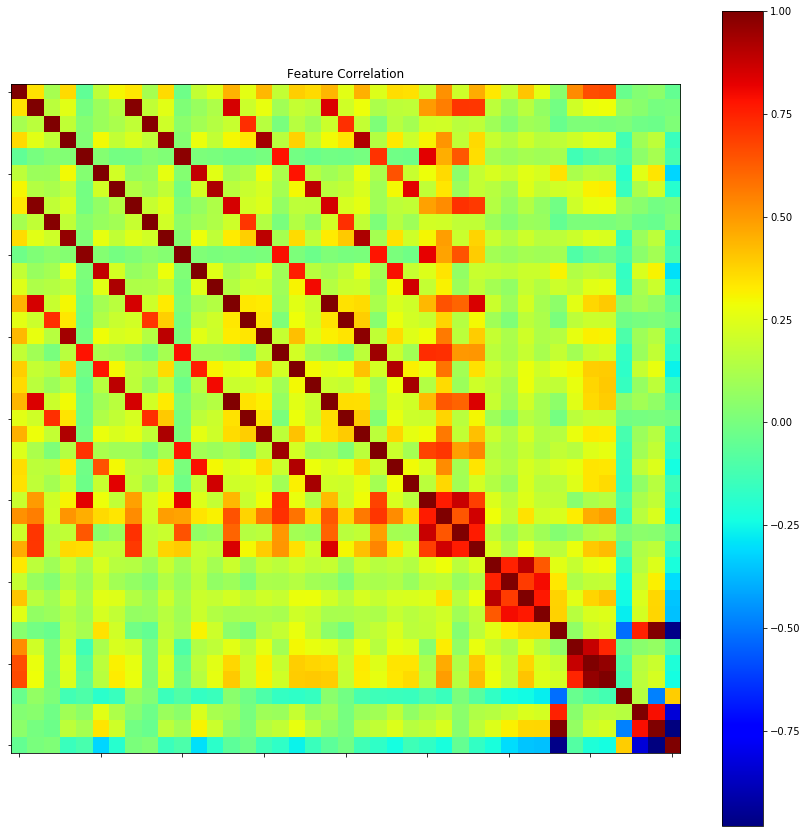

In [440]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 1000)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(False)
    plt.title('Feature Correlation')
    labels=['']*len(X.columns)
    ax1.set_xticklabels(labels,fontsize=25)
    ax1.set_yticklabels(labels,fontsize=25)
    fig.colorbar(cax, ticks=np.arange(-1,1.1,.25))
    plt.show()

correlation_matrix(X)

In [443]:
est = make_pipeline(PolynomialFeatures(2), LassoCV(alphas=[1e-10], cv=5))
est.fit(X, y)
scored.append(est.score(X, y))


(0, 200)

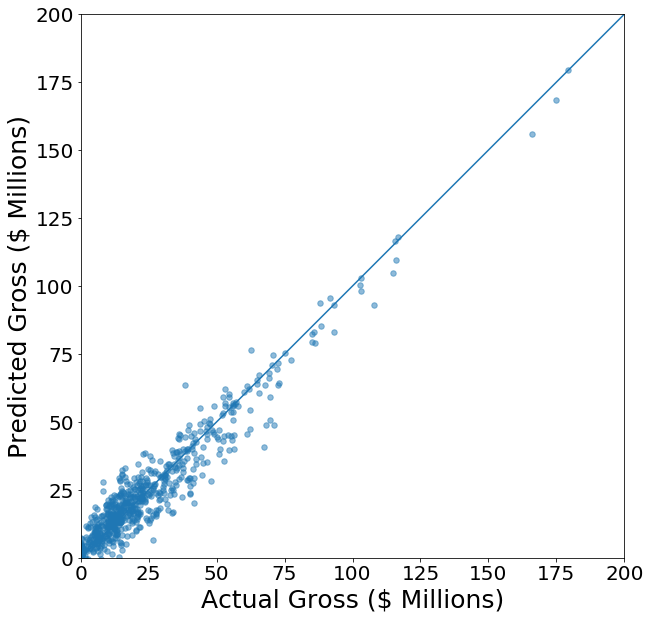

In [444]:
plt.figure(figsize=(15,10))
plt.plot([0,200],[0,200])
plt.tick_params(labelsize=20)
plt.scatter(y/1e6,est.predict(X)/1e6,s=30,alpha=.5)
plt.axis('scaled')
plt.ylabel('Predicted Gross ($ Millions)', fontsize=25)
plt.xlabel('Actual Gross ($ Millions)', fontsize=25)

plt.ylim([0,200])
plt.xlim([0,200])


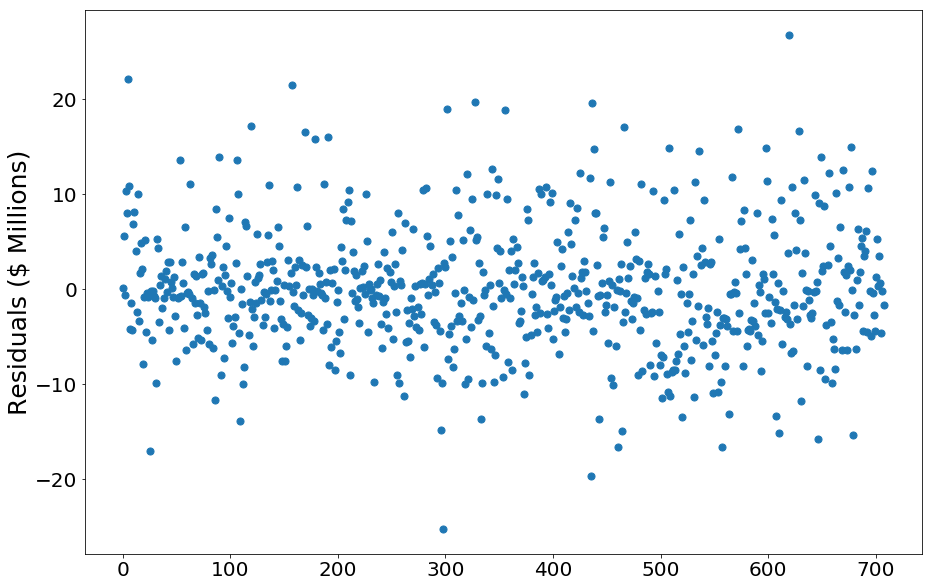

In [417]:
plt.figure(figsize=(15,10))
plt.tick_params(labelsize=20)
plt.scatter(range(len(y)), (y-est.predict(X))/1e6,s=50,alpha=1)
plt.axis('tight')
plt.ylabel('Residuals ($ Millions)', fontsize=25)
plt.xlabel('', fontsize=25);


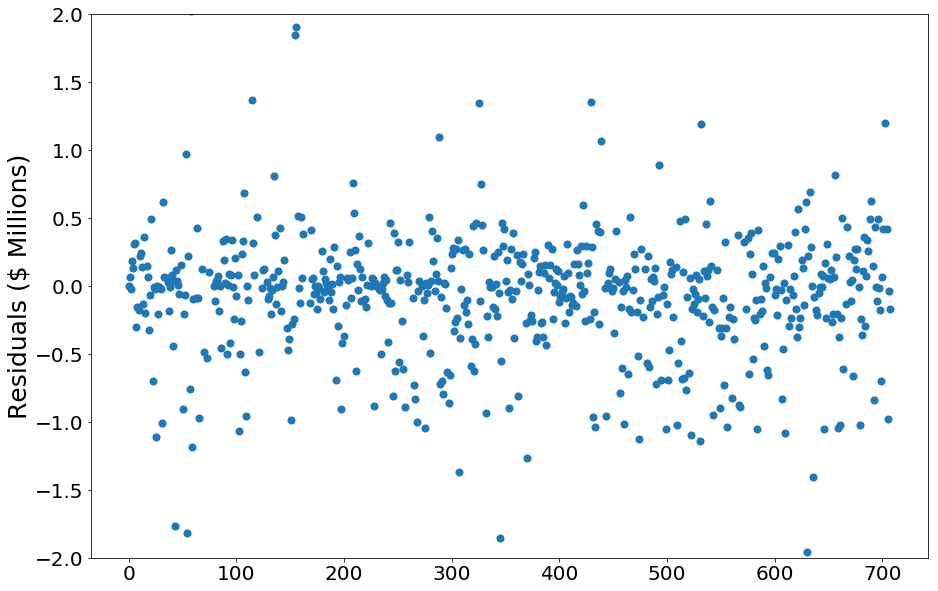

In [449]:
plt.figure(figsize=(15,10))
plt.tick_params(labelsize=20)
plt.scatter(range(len(y)), (y-est.predict(X))/y,s=50,alpha=1)
plt.axis('tight')
plt.ylabel('Residuals ($ Millions)', fontsize=25)
plt.xlabel('', fontsize=25)
plt.ylim([-2,2]);


In [418]:
np.std(y-est.predict(X))

6426132.4748780727

In [452]:
resid = (y-est.predict(X))/y
resid = resid[resid>-10]
np.std(resid)

56.953820912925302

# Extra Plots

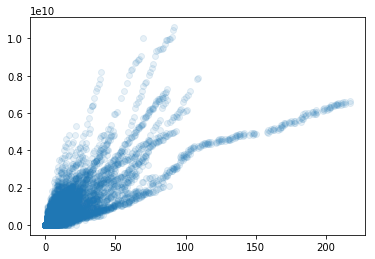

In [234]:
plt.scatter(crew_dat['Nmovie'], crew_dat['GrossAccum'], alpha=.1);

Let's look at individual crew, see if we can identify people:

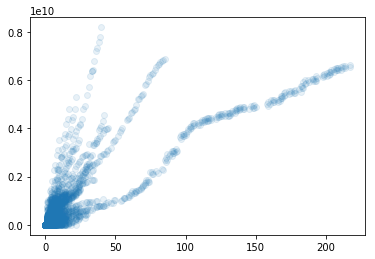

In [270]:
exproducer = crew_dat[crew_dat['Credit']=='Executive Producer']
plt.scatter(exproducer['Nmovie'], exproducer['GrossAccum'], alpha=.1);

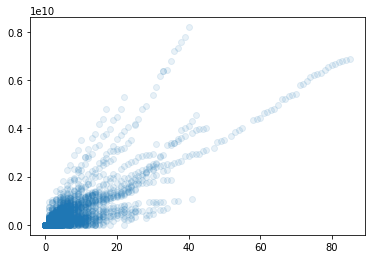

In [271]:
#Remove Weinstein Bros., who have most movies
exproducer = exproducer[exproducer['Name']!='Bob Weinstein']
exproducer = exproducer[exproducer['Name']!='Harvey Weinstein']

plt.scatter(exproducer['Nmovie'], exproducer['GrossAccum'], alpha=.1);


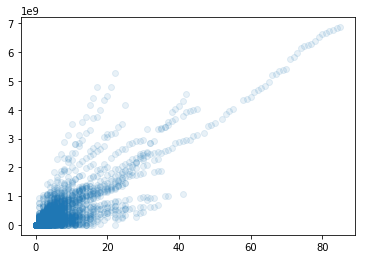

In [272]:
#Remove Stan Lee, who has highest gross accumulation
exproducer = exproducer[exproducer['Name']!='Stan Lee']

plt.scatter(exproducer['Nmovie'], exproducer['GrossAccum'], alpha=.1);


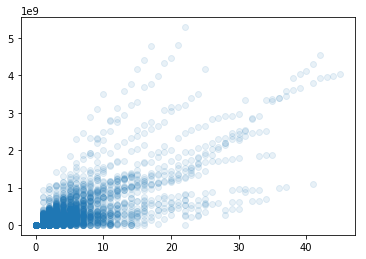

In [273]:
#Remove Bruce Berman, next highest gross accumulation and number of movies
exproducer = exproducer[exproducer['Name']!='Bruce Berman']

plt.scatter(exproducer['Nmovie'], exproducer['GrossAccum'], alpha=.1);

Other crew

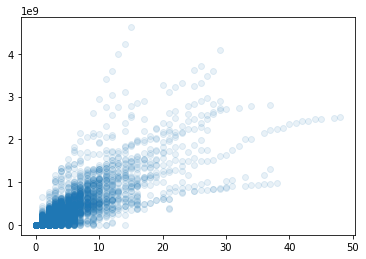

In [230]:
producer = crew_dat[crew_dat['Credit']=='Producer']
plt.scatter(producer['Nmovie'], producer['GrossAccum'], alpha=.1);

Make sure we're getting most of the data.

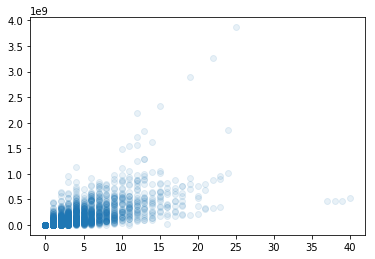

In [231]:
director = crew_dat[crew_dat['Credit']=='Director']
plt.scatter(director['Nmovie'], director['GrossAccum'], alpha=.1);

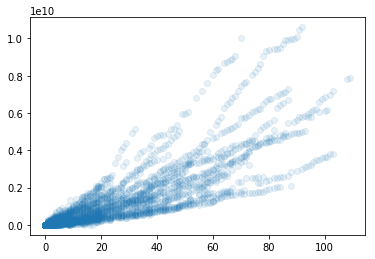

In [232]:
composer = crew_dat[crew_dat['Credit']=='Composer']
plt.scatter(composer['Nmovie'], composer['GrossAccum'], alpha=.1);

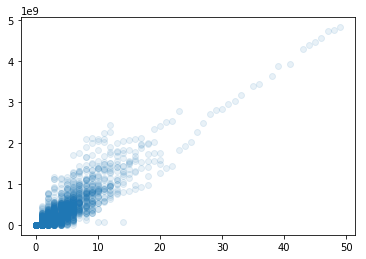

In [233]:
editor = crew_dat[crew_dat['Credit']=='Editor']
plt.scatter(editor['Nmovie'], editor['GrossAccum'], alpha=.1);

In [276]:
crew_dat.head()

,Name,Movie,Credit,URL,Nmovie,GrossAccum
0,James Cameron,Avatar,Editor,/person/23100401-James-Cameron,0.0,0.000000e+00
1,Jon Landau,Avatar,Producer,/person/190420401-Jon-Landau,2.0,6.736423e+08
2,Colin Wilson,Avatar,Executive Producer,/person/206830401-Colin-Wilson,0.0,0.000000e+00
3,Laeta Kalogridis,Avatar,Executive Producer,/person/423570401-Laeta-Kalogridis,0.0,0.000000e+00
4,Stephen Rivkin,Avatar,Editor,/person/121990401-Stephen-Rivkin,9.0,1.338623e+09


1915

In [223]:
len(crew_dat.dropna())/len(crew_dat)

0.9584198043284909